Core Libraries:

In [1]:
pip install symspellpy==6.5.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.6/2.6 MB 26.1 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
from PIL import Image
import cv2
import nltk
import argparse
import pprint
from ast import literal_eval
from plotly.offline import init_notebook_mode, iplot
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler, LabelBinarizer
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from scipy.ndimage import rotate
import itertools
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from collections import Counter
from sklearn.metrics import accuracy_score,roc_curve,auc
sns.set(style='white', context='notebook', palette='deep')
import sys
sys.path.append("/kaggle/input/artemis-utils")
from basic import make_train_test_val_splits
from vocabulary import build_vocab
from langbasics import tokenize_and_spell

ArtEmis Dataset:

In [3]:
# Load ArtEmis data
datapath = '/kaggle/input/wikiart'
artemis_datapath = '/kaggle/input/artemis-dataset'

# Load ArtEmis data
data = pd.read_csv(artemis_datapath+'/artemis_dataset_release_v0.csv')
data.head()

,art_style,painting,emotion,utterance,repetition
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"She seems very happy in the picture, and you w...",10
1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,sadness,This woman has really knotty hands which makes...,10
2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,something else,"When looking at this woman, I am filled with c...",10
3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,contentment,"A woman looking at ease, peaceful, and satisfi...",10
4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,awe,She looks like a lady from that past that migh...,10


In [4]:
# Check for missing values
print(f"data:\n{data.isnull().sum()}\n")

# Identify invalid filenames
def find_invalid_filenames(dataframe, base_dir):
    invalid_files = []
    for _, row in dataframe.iterrows():
        filename = f"{row['art_style']}/{row['painting']}.jpg"
        file_path = os.path.join(base_dir, filename)
        if not os.path.isfile(file_path):
            invalid_files.append(filename)
    return invalid_files
    
invalid_filenames = find_invalid_filenames(data, datapath)
print(f"Number of invalid files in train data: {len(invalid_filenames)}")

data:
art_style     0
painting      0
emotion       0
utterance     0
repetition    0
dtype: int64

Number of invalid files in train data: 4129


In [5]:
# Remove invalid filenames from dataset
data['filename'] = data['art_style'] + '/' + data['painting']+'.jpg'
cleaned_data = data[~data['filename'].isin(invalid_filenames)]
print(f"Number of valid rows in train after cleaning: {len(cleaned_data)}")

Number of valid rows in train after cleaning: 450555


In [6]:
#Extract and map unique emotions
emotions_classes =  cleaned_data['emotion'].unique()
emotions_mapping = {emotion: idx for idx, emotion in enumerate(emotions_classes)}

print(f"Emotions:\n{emotions_mapping}\n")

cleaned_data.loc[:, 'emotion'] = cleaned_data['emotion'].map(emotions_mapping)
cleaned_data.head()

Emotions:
{'something else': 0, 'sadness': 1, 'contentment': 2, 'awe': 3, 'amusement': 4, 'excitement': 5, 'fear': 6, 'disgust': 7, 'anger': 8}



,art_style,painting,emotion,utterance,repetition,filename
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,0,"She seems very happy in the picture, and you w...",10,Post_Impressionism/vincent-van-gogh_portrait-o...
1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,1,This woman has really knotty hands which makes...,10,Post_Impressionism/vincent-van-gogh_portrait-o...
2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,0,"When looking at this woman, I am filled with c...",10,Post_Impressionism/vincent-van-gogh_portrait-o...
3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,2,"A woman looking at ease, peaceful, and satisfi...",10,Post_Impressionism/vincent-van-gogh_portrait-o...
4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,3,She looks like a lady from that past that migh...,10,Post_Impressionism/vincent-van-gogh_portrait-o...


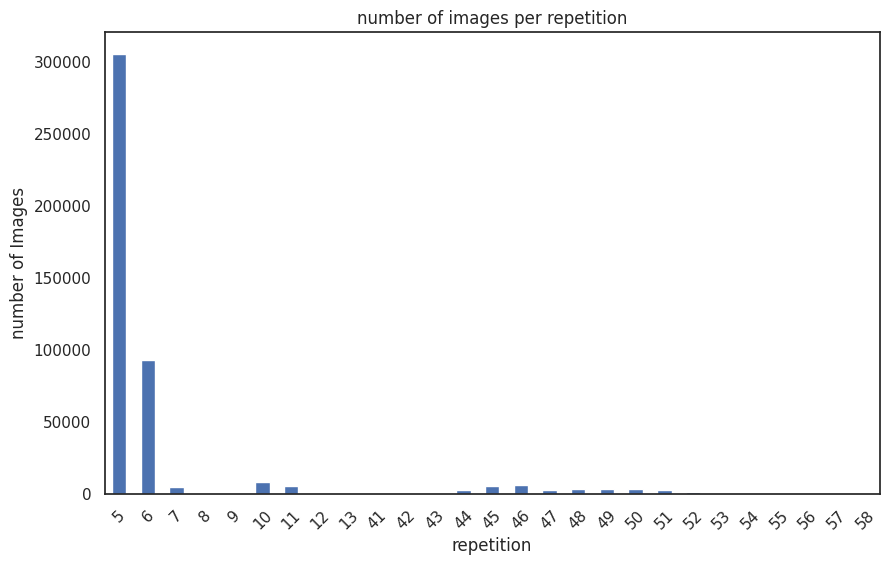

In [7]:
# Visualize the emotions distribution
def visualize_data(data,column):
    data = (data[column].value_counts())
    data.sort_index().plot(kind='bar', figsize=(10, 6), legend=False)
    plt.title(f"number of images per {column}")
    plt.ylabel("number of Images")
    plt.xlabel(column)
    plt.xticks(rotation=45)
    plt.show()
visualize_data(cleaned_data,'repetition')

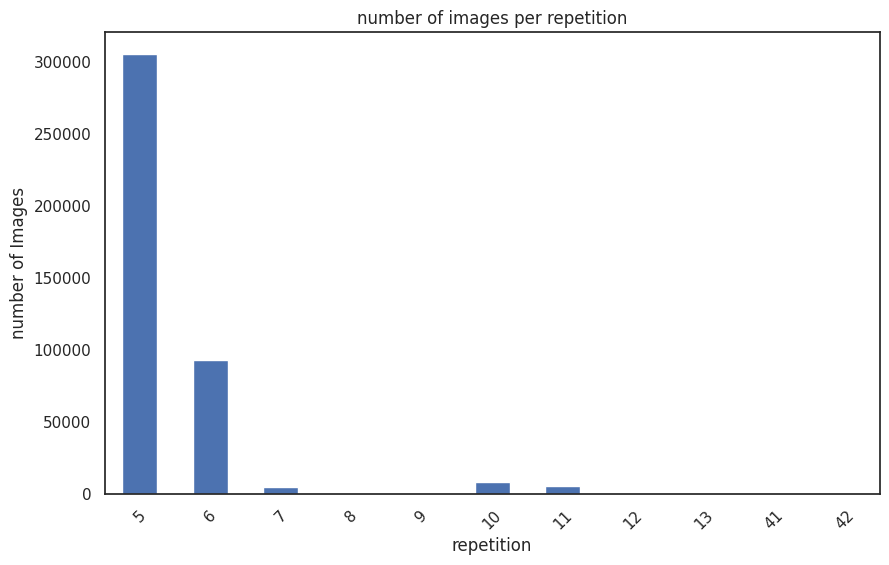

In [8]:
# Remove artworks with repetition > 43
too_high_repetition = 43
normal_rep_mask = cleaned_data.repetition < too_high_repetition
high_coverage_df = cleaned_data[~normal_rep_mask]
high_coverage_df.reset_index(drop=True, inplace=True)
high_coverage_df = high_coverage_df.assign(split=len(high_coverage_df)*['rest'])
cleaned_data = cleaned_data[normal_rep_mask]
cleaned_data.reset_index(drop=True, inplace=True)

visualize_data(cleaned_data,'repetition')

In [9]:
# split the data in train/val/test
cleaned_data = make_train_test_val_splits(cleaned_data, [0.85, 0.05, 0.1], 2021)
cleaned_data.head()

Using a 0.85,0.05,0.1 for train/val/test purposes


,art_style,painting,emotion,utterance,repetition,filename,split
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,0,"She seems very happy in the picture, and you w...",10,Post_Impressionism/vincent-van-gogh_portrait-o...,train
1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,1,This woman has really knotty hands which makes...,10,Post_Impressionism/vincent-van-gogh_portrait-o...,train
2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,0,"When looking at this woman, I am filled with c...",10,Post_Impressionism/vincent-van-gogh_portrait-o...,train
3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,2,"A woman looking at ease, peaceful, and satisfi...",10,Post_Impressionism/vincent-van-gogh_portrait-o...,train
4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,3,She looks like a lady from that past that migh...,10,Post_Impressionism/vincent-van-gogh_portrait-o...,train


SymSpell spell-checker loaded: True
Loading glove word embeddings.
Done. 400000 words loaded.
Updating Glove vocabulary with *valid* ArtEmis words that are missing from it.


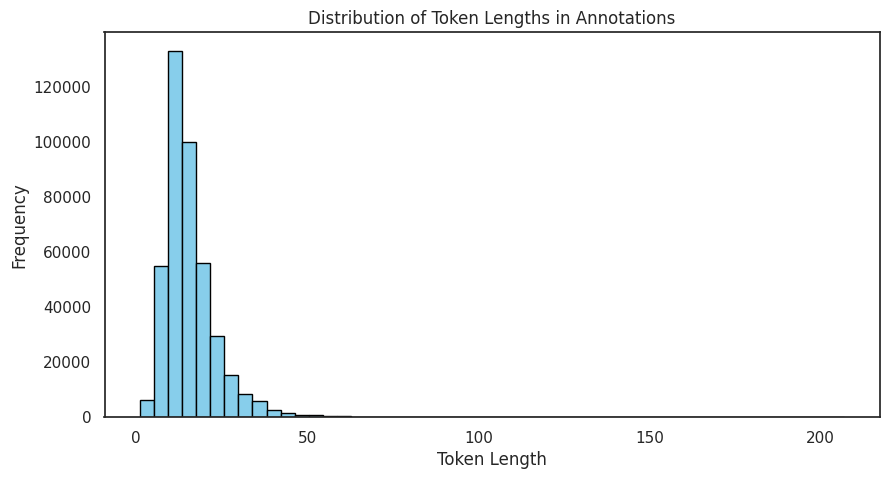

In [10]:
# Apply-spell checking
freq_file = '/kaggle/input/artemis-utils/symspell_frequency_dictionary_en_82_765.txt'
glove_file = '/kaggle/input/artemis-utils/glove.6B.100d.vocabulary.txt'
missed_tokens = tokenize_and_spell(cleaned_data, glove_file, freq_file, nltk.word_tokenize, spell_check=True)

# Plot histogram of token lengths
plt.figure(figsize=(10, 5))
plt.hist(cleaned_data.tokens_len, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths in Annotations")
plt.show()

In [11]:
# Drop too long/short tokens
too_short_len = 3
too_long_utter_prc = 98
too_short_mask = cleaned_data.tokens_len < too_short_len
print('{} annotations will be dropped as they contain less than {} tokens'.format(sum(too_short_mask), too_short_len))
too_long_len = np.percentile(cleaned_data[cleaned_data.split == 'train']['tokens_len'], too_long_utter_prc)
too_long_mask = cleaned_data.tokens_len > too_long_len
print('Too-long token length at {}-percentile is {}. {} annotations will be dropped'.format(too_long_utter_prc,
                                                                                            too_long_len, sum(too_long_mask)))
cleaned_data = cleaned_data[~too_short_mask & ~too_long_mask]
cleaned_data.reset_index(drop=True, inplace=True)

318 annotations will be dropped as they contain less than 3 tokens
Too-long token length at 98-percentile is 38.0. 7788 annotations will be dropped


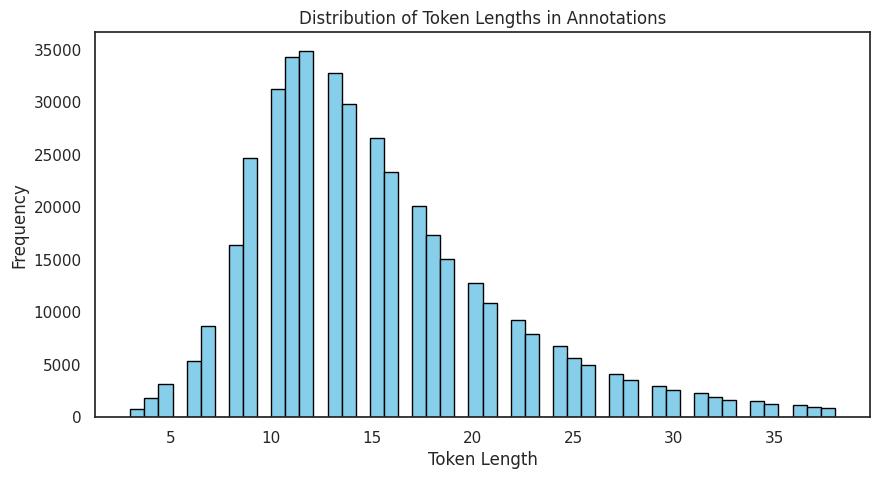

In [12]:
# Plot histogram of token lengths
plt.figure(figsize=(10, 5))
plt.hist(cleaned_data.tokens_len, bins=50, color='skyblue', edgecolor='black')
plt.xlabel("Token Length")
plt.ylabel("Frequency")
plt.title("Distribution of Token Lengths in Annotations")
plt.show()

In [13]:
cleaned_data.head()

,art_style,painting,emotion,utterance,repetition,filename,split,tokens,tokens_len,utterance_spelled
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,0,"She seems very happy in the picture, and you w...",10,Post_Impressionism/vincent-van-gogh_portrait-o...,train,"[she, seems, very, happy, in, the, picture, an...",18,she seems very happy in the picture and you wa...
1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,1,This woman has really knotty hands which makes...,10,Post_Impressionism/vincent-van-gogh_portrait-o...,train,"[this, woman, has, really, knotty, hands, whic...",14,this woman has really knotty hands which makes...
2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,0,"When looking at this woman, I am filled with c...",10,Post_Impressionism/vincent-van-gogh_portrait-o...,train,"[when, looking, at, this, woman, i, am, filled...",27,when looking at this woman i am filled with cu...
3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,2,"A woman looking at ease, peaceful, and satisfi...",10,Post_Impressionism/vincent-van-gogh_portrait-o...,train,"[a, woman, looking, at, ease, peaceful, and, s...",15,a woman looking at ease peaceful and satisfied...
4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,3,She looks like a lady from that past that migh...,10,Post_Impressionism/vincent-van-gogh_portrait-o...,train,"[she, looks, like, a, lady, from, that, past, ...",33,she looks like a lady from that past that migh...


In [14]:
# Make a word-vocabulary based on training data
train_tokens = cleaned_data[cleaned_data.split =='train']['tokens']
vocab = build_vocab(train_tokens, 0)
print('Using a vocabulary with {} tokens'.format(len(vocab)))

# Encode tokens as ints
max_len = int(too_long_len)
cleaned_data['tokens_encoded'] = cleaned_data.tokens.apply(lambda x: vocab.encode(x, max_len))

cleaned_data.head()

Using a vocabulary with 33392 tokens


,art_style,painting,emotion,utterance,repetition,filename,split,tokens,tokens_len,utterance_spelled,tokens_encoded
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,0,"She seems very happy in the picture, and you w...",10,Post_Impressionism/vincent-van-gogh_portrait-o...,train,"[she, seems, very, happy, in, the, picture, an...",18,she seems very happy in the picture and you wa...,"[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ..."
1,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,1,This woman has really knotty hands which makes...,10,Post_Impressionism/vincent-van-gogh_portrait-o...,train,"[this, woman, has, really, knotty, hands, whic...",14,this woman has really knotty hands which makes...,"[1, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30..."
2,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,0,"When looking at this woman, I am filled with c...",10,Post_Impressionism/vincent-van-gogh_portrait-o...,train,"[when, looking, at, this, woman, i, am, filled...",27,when looking at this woman i am filled with cu...,"[1, 32, 33, 34, 20, 21, 35, 36, 37, 38, 39, 40..."
3,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,2,"A woman looking at ease, peaceful, and satisfi...",10,Post_Impressionism/vincent-van-gogh_portrait-o...,train,"[a, woman, looking, at, ease, peaceful, and, s...",15,a woman looking at ease peaceful and satisfied...,"[1, 45, 21, 33, 34, 48, 49, 11, 50, 51, 28, 52..."
4,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,3,She looks like a lady from that past that migh...,10,Post_Impressionism/vincent-van-gogh_portrait-o...,train,"[she, looks, like, a, lady, from, that, past, ...",33,she looks like a lady from that past that migh...,"[1, 4, 56, 30, 45, 57, 58, 59, 60, 59, 61, 62,..."


In [15]:
# Save preprocessed data
cleaned_data.to_csv('/kaggle/working/artemis_preprocessed.csv', index=False)

# Save vocabulary
vocab.save('/kaggle/working/vocabulary.pkl')

print('n-utterances kept:', len(cleaned_data))
print('vocab size:', len(vocab))
print('tokens not in Glove/Manual vocabulary:', len(missed_tokens))

n-utterances kept: 409388
vocab size: 33392
tokens not in Glove/Manual vocabulary: 580


In [16]:
histogram_data = pd.read_csv(artemis_datapath+'/image-emotion-histogram.csv')
histogram_data.head()

,art_style,painting,emotion_histogram
0,Abstract_Expressionism,aaron-siskind_acolman-1-1955,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0]"
1,Abstract_Expressionism,aaron-siskind_chicago-1951,"[0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 2.0, 1.0, 1.0]"
2,Abstract_Expressionism,aaron-siskind_chicago-6-1961,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 3.0, 0.0, 2.0]"
3,Abstract_Expressionism,aaron-siskind_feet-102-1957,"[0.0, 0.0, 1.0, 0.0, 0.0, 2.0, 0.0, 0.0, 2.0]"
4,Abstract_Expressionism,aaron-siskind_gloucester-16a-1944,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 4.0]"


In [17]:
# this literal_eval brings the saved string to its corresponding native (list) type
histogram_data.emotion_histogram = histogram_data.emotion_histogram.apply(literal_eval)

# normalize the histograms
histogram_data.emotion_histogram = histogram_data.emotion_histogram.apply(lambda x: (np.array(x) / float(sum(x))).astype('float32'))

print(f'Histograms corresponding to {len(histogram_data)} images')

Histograms corresponding to 80031 images


In [18]:
# Merge artemis dataset with the emotion-histograms.)
artemis_data = pd.read_csv(os.path.join('/kaggle/working', 'artemis_preprocessed.csv'))
print('Annotations loaded:', len(artemis_data))

## keep each image once.
artemis_data = artemis_data.drop_duplicates(subset=['art_style', 'painting'])
artemis_data.reset_index(inplace=True, drop=True)

# keep only relevant info + merge
artemis_data = artemis_data[['art_style', 'painting', 'split','tokens','tokens_encoded']] 
artemis_data = artemis_data.merge(histogram_data)
artemis_data = artemis_data.rename(columns={'emotion_histogram': 'emotion_distribution'})

n_emotions = len(histogram_data.emotion_histogram[0])
print('Using {} emotion-classes.'.format(n_emotions))
assert all(histogram_data.emotion_histogram.apply(len) == n_emotions)

Annotations loaded: 409388
Using 9 emotion-classes.


In [19]:
artemis_data.head()

,art_style,painting,split,tokens,tokens_encoded,emotion_distribution
0,Post_Impressionism,vincent-van-gogh_portrait-of-madame-ginoux-l-a...,train,"['she', 'seems', 'very', 'happy', 'in', 'the',...","[1, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, ...","[0.0, 0.1, 0.2, 0.0, 0.0, 0.1, 0.1, 0.2, 0.3]"
1,Expressionism,wassily-kandinsky_study-for-autumn-1909,train,"['the', 'bright', 'colors', 'make', 'a', 'very...","[1, 9, 77, 78, 79, 45, 6, 80, 81, 73, 9, 82, 8...","[0.2857143, 0.42857143, 0.0, 0.0, 0.0, 0.14285..."
2,Impressionism,konstantin-korovin_yaroslavna-s-lament-1909,train,"['the', 'stroke', 'of', 'blue', 'paint', 'used...","[1, 9, 84, 85, 86, 87, 88, 14, 89, 9, 90, 8, 9...","[0.42857143, 0.14285715, 0.2857143, 0.0, 0.0, ..."
3,Impressionism,paul-gauguin_mette-gauguin-in-an-evening-dress...,train,"['the', 'golden', 'gloves', 'and', 'white', 'd...","[1, 9, 98, 99, 11, 100, 101, 102, 103, 11, 17,...","[0.2857143, 0.14285715, 0.14285715, 0.14285715..."
4,Impressionism,pericles-pantazis_still-life-with-quinces-1880,train,"['the', 'pears', 'are', 'just', 'about', 'ripe...","[1, 9, 116, 95, 117, 40, 118, 14, 119, 11, 120...","[0.0, 0.0, 0.85714287, 0.0, 0.0, 0.0, 0.0, 0.0..."


In [20]:
# Image-net Normalization
image_net_mean = [0.485, 0.456, 0.406]
image_net_std = [0.229, 0.224, 0.225]

# Transformation
def image_transformation(img_dim):
    resample_method = Image.LANCZOS
    normalize = transforms.Normalize(mean=image_net_mean, std=image_net_std)
    img_transforms = dict()
    img_transforms['train'] = transforms.Compose([transforms.Resize((img_dim, img_dim), resample_method),
                                                  transforms.ToTensor(),
                                                  normalize])
    img_transforms['test'] = img_transforms['train']
    img_transforms['val'] = img_transforms['train']
    return img_transforms

In [25]:
class ImageClassificationDataset(Dataset):
    def __init__(self, image_files, labels=None, img_transform=None, rgb_only=True):
        super(ImageClassificationDataset, self).__init__()
        self.image_files = image_files
        self.labels = labels
        self.img_transform = img_transform
        self.rgb_only = rgb_only

    def __getitem__(self, index):
        img = Image.open(self.image_files[index])        
        if self.rgb_only and img.mode != 'RGB':  
            img = img.convert('RGB') 
        if self.img_transform is not None:
            img = self.img_transform(img)
        labels = {
            "emotion_distribution": self.labels["emotion_distribution"][index],
            "tokens": self.labels["tokens"][index],
            "tokens_encoded": self.labels["tokens_encoded"][index]
        }
        return {"image": img, "labels": labels, "index": index}
    
    def __len__(self):
        return len(self.image_files)

In [26]:
# Create datasets and dataloaders
dataloaders = dict()
datasets = dict()
batch_size = 32
img_transforms = image_transformation(256)

for split, g in artemis_data.groupby('split'):
    g.reset_index(inplace=True, drop=True)
    img_files = g.apply(lambda x : os.path.join(datapath, x.art_style,  x.painting + '.jpg'), axis=1)
    img_files.name = 'image_files'
    dataset = ImageClassificationDataset(
        image_files=img_files, 
        labels={
            "emotion_distribution": g.emotion_distribution,
            "tokens": g.tokens,
            "tokens_encoded": g.tokens_encoded
        },
        img_transform=img_transforms[split]
    )
    datasets[split] = dataset
    b_size = batch_size if split=='train' else batch_size * 2
    dataloaders[split] = torch.utils.data.DataLoader(dataset=dataset,
                                                     batch_size=b_size,
                                                     shuffle=split=='train',
                                                     )

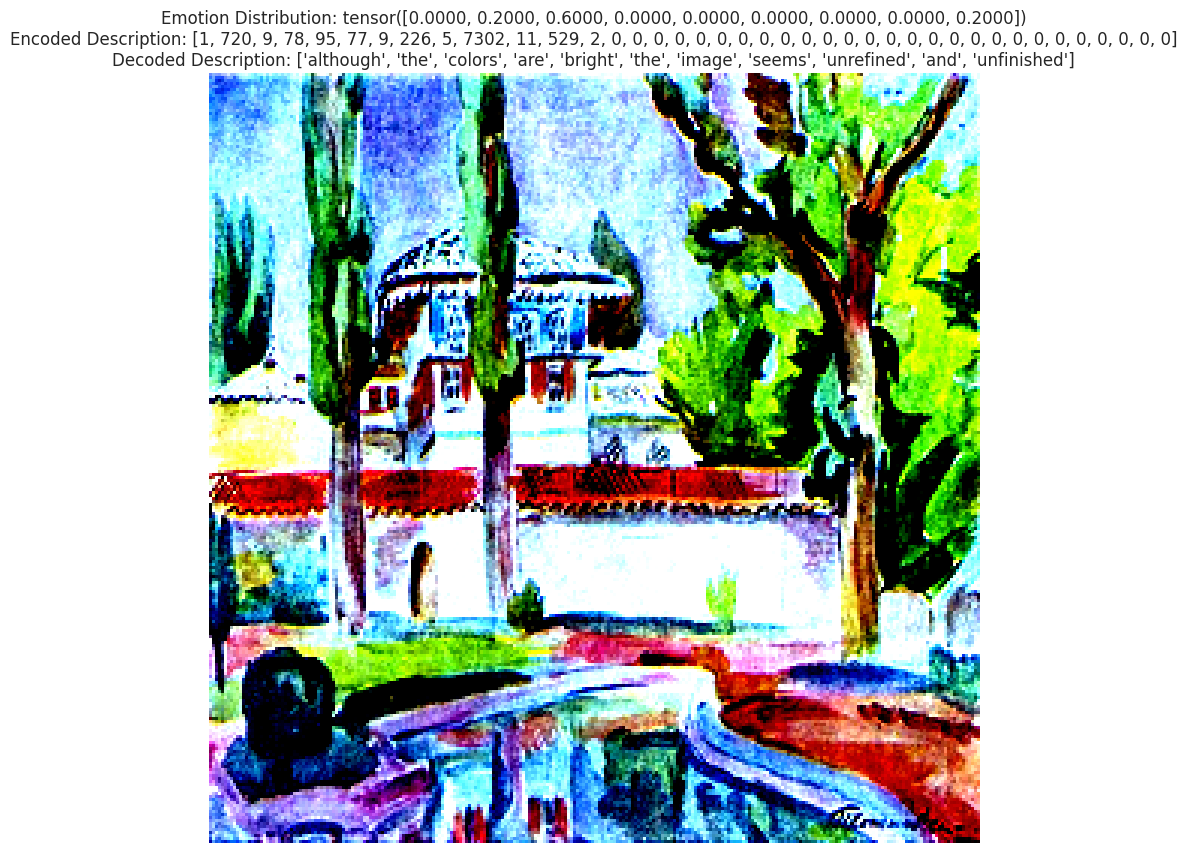

In [37]:
# Visualize training image from train loader
sample_batch = next(iter(dataloaders['train']))
image_tensor = sample_batch['image'][0]
labels = sample_batch['labels']
# Convert tensor image to numpy for visualization
if isinstance(image_tensor, torch.Tensor):
    # Convert CHW -> HWC
    image_numpy = image_tensor.permute(1, 2, 0).numpy()

emotion_label = labels['emotion_distribution'][0]
token_label = labels['tokens'][0]
token_encoded_label = labels['tokens_encoded'][0]
# Plot the image
plt.figure(figsize=(20, 10))
plt.imshow(image_numpy)
plt.title(f'Emotion Distribution: {emotion_label}\nEncoded Description: {token_encoded_label}\nDecoded Description: {token_label}')
plt.axis('off')
plt.show()